<a href="https://colab.research.google.com/github/jfink09/Financial-Modeling/blob/Time-Series-Modeling/Testing_for_stationarity_in_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Testing for stationarity in time series
# Using the program 'decomposing time series' to show correction

# Set up plots
%matplotlib inline
%config InclineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt 
import warnings

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [0]:
# Install Quandl
!pip install --upgrade quandl

Requirement already up-to-date: quandl in /usr/local/lib/python3.6/dist-packages (3.5.0)


In [0]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import quandl

# Use the seasonal_decompose function from the statsmodels library to carry out the classical decomposition
# This indicates that we will either use either the additive or multiplicative model
from statsmodels.tsa.seasonal import seasonal_decompose

In [0]:
# Testing for stationarity in time series

# Import libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss

In [0]:
# Input your API key from the Quandl account
QUANDL_KEY = '{key}'
quandl.ApiConfig.api_key = QUANDL_KEY

In [0]:
# Download the gold prices data from Quandl
df = quandl.get(dataset='WGC/GOLD_MONAVG_USD',authtoken='key', start_date='2000-01-01', end_date='2011-12-31')

# Rename the value column to price
df.rename(columns={'Value': 'price'}, inplace=True)

# There may be an entry for 2000-04-28 and 2000-04-30, both with the same value 
# So resampling to monthly data by only taking the last value takes care of duplicated data in the series
# Only take data from the last day of the month 
# This was done by resampling the data to a monthly frequency
# This gives us only one data point per month
# This process does not change any of the actual values
df = df.resample('M').last()

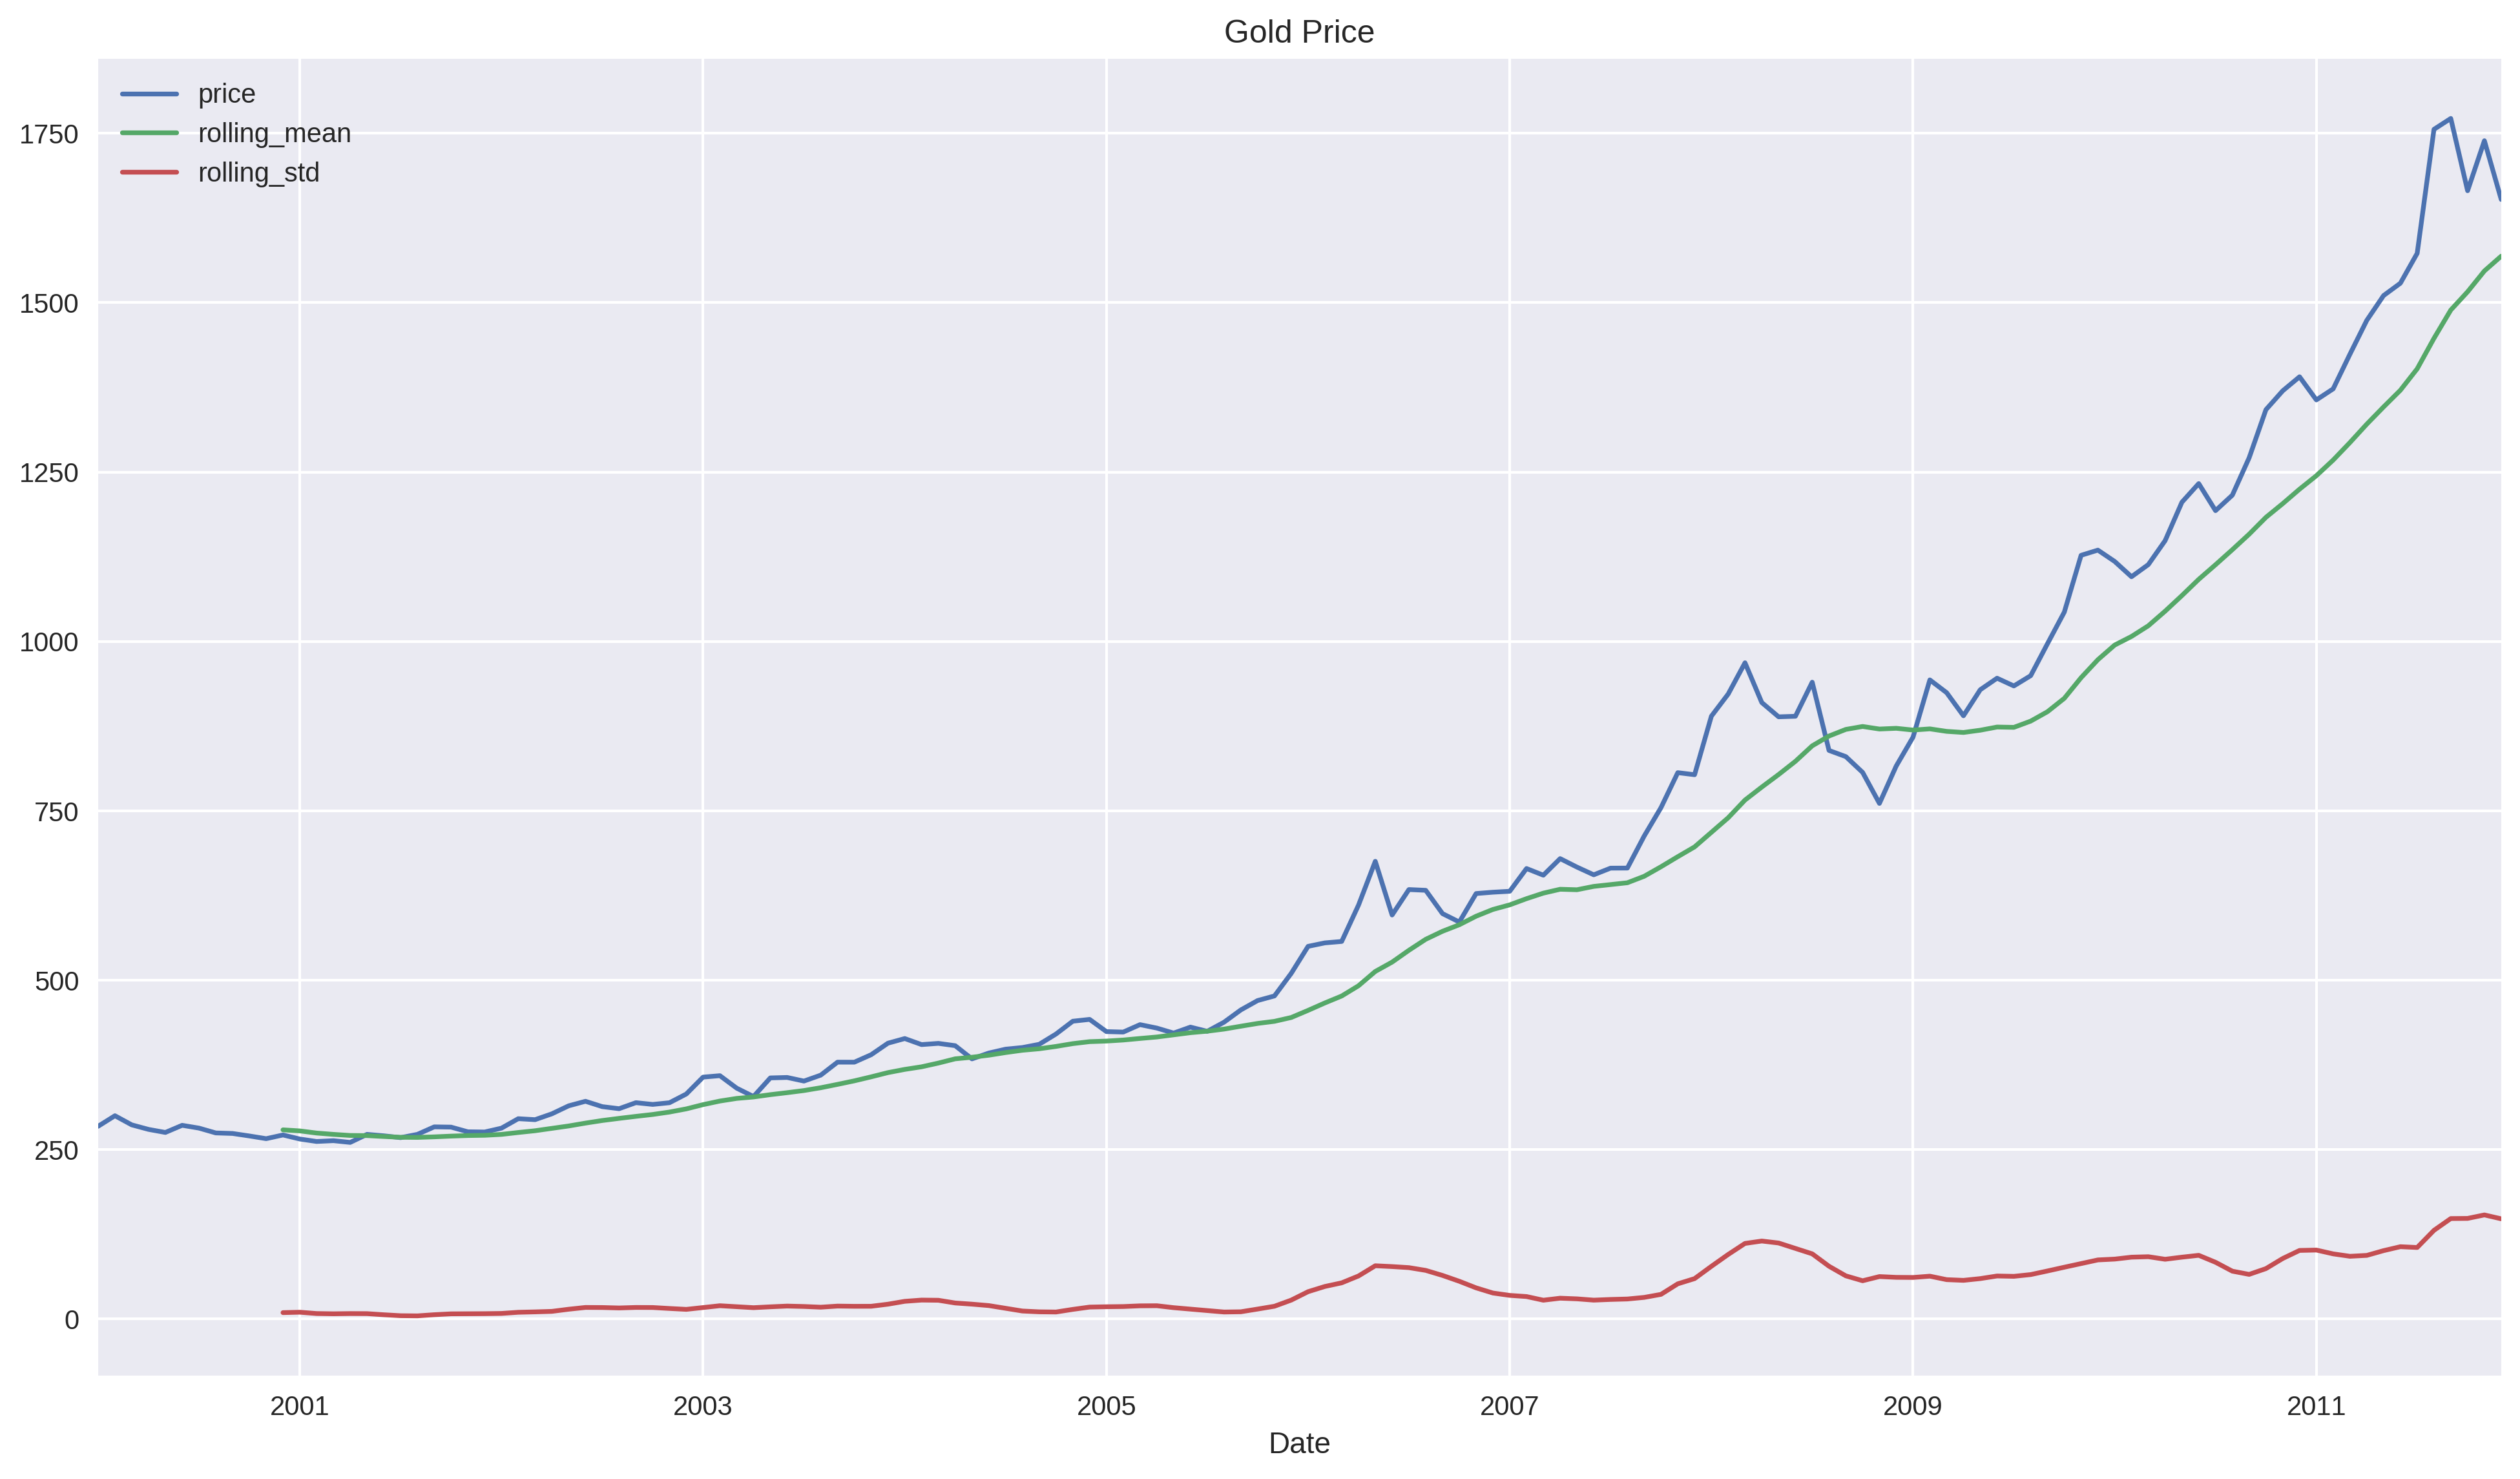

In [0]:
# Make the window size for the rolling statisitcs a 12 month time period 
WINDOW_SIZE = 12

# Calculate the rolling mean and rolling standard deviation of the data
df['rolling_mean'] = df.price.rolling(window=WINDOW_SIZE).mean()
df['rolling_std'] = df.price.rolling(window=WINDOW_SIZE).std()

# Plot the gold price, rolling mean, and rolling standard deviation
df.plot(title='Gold Price')

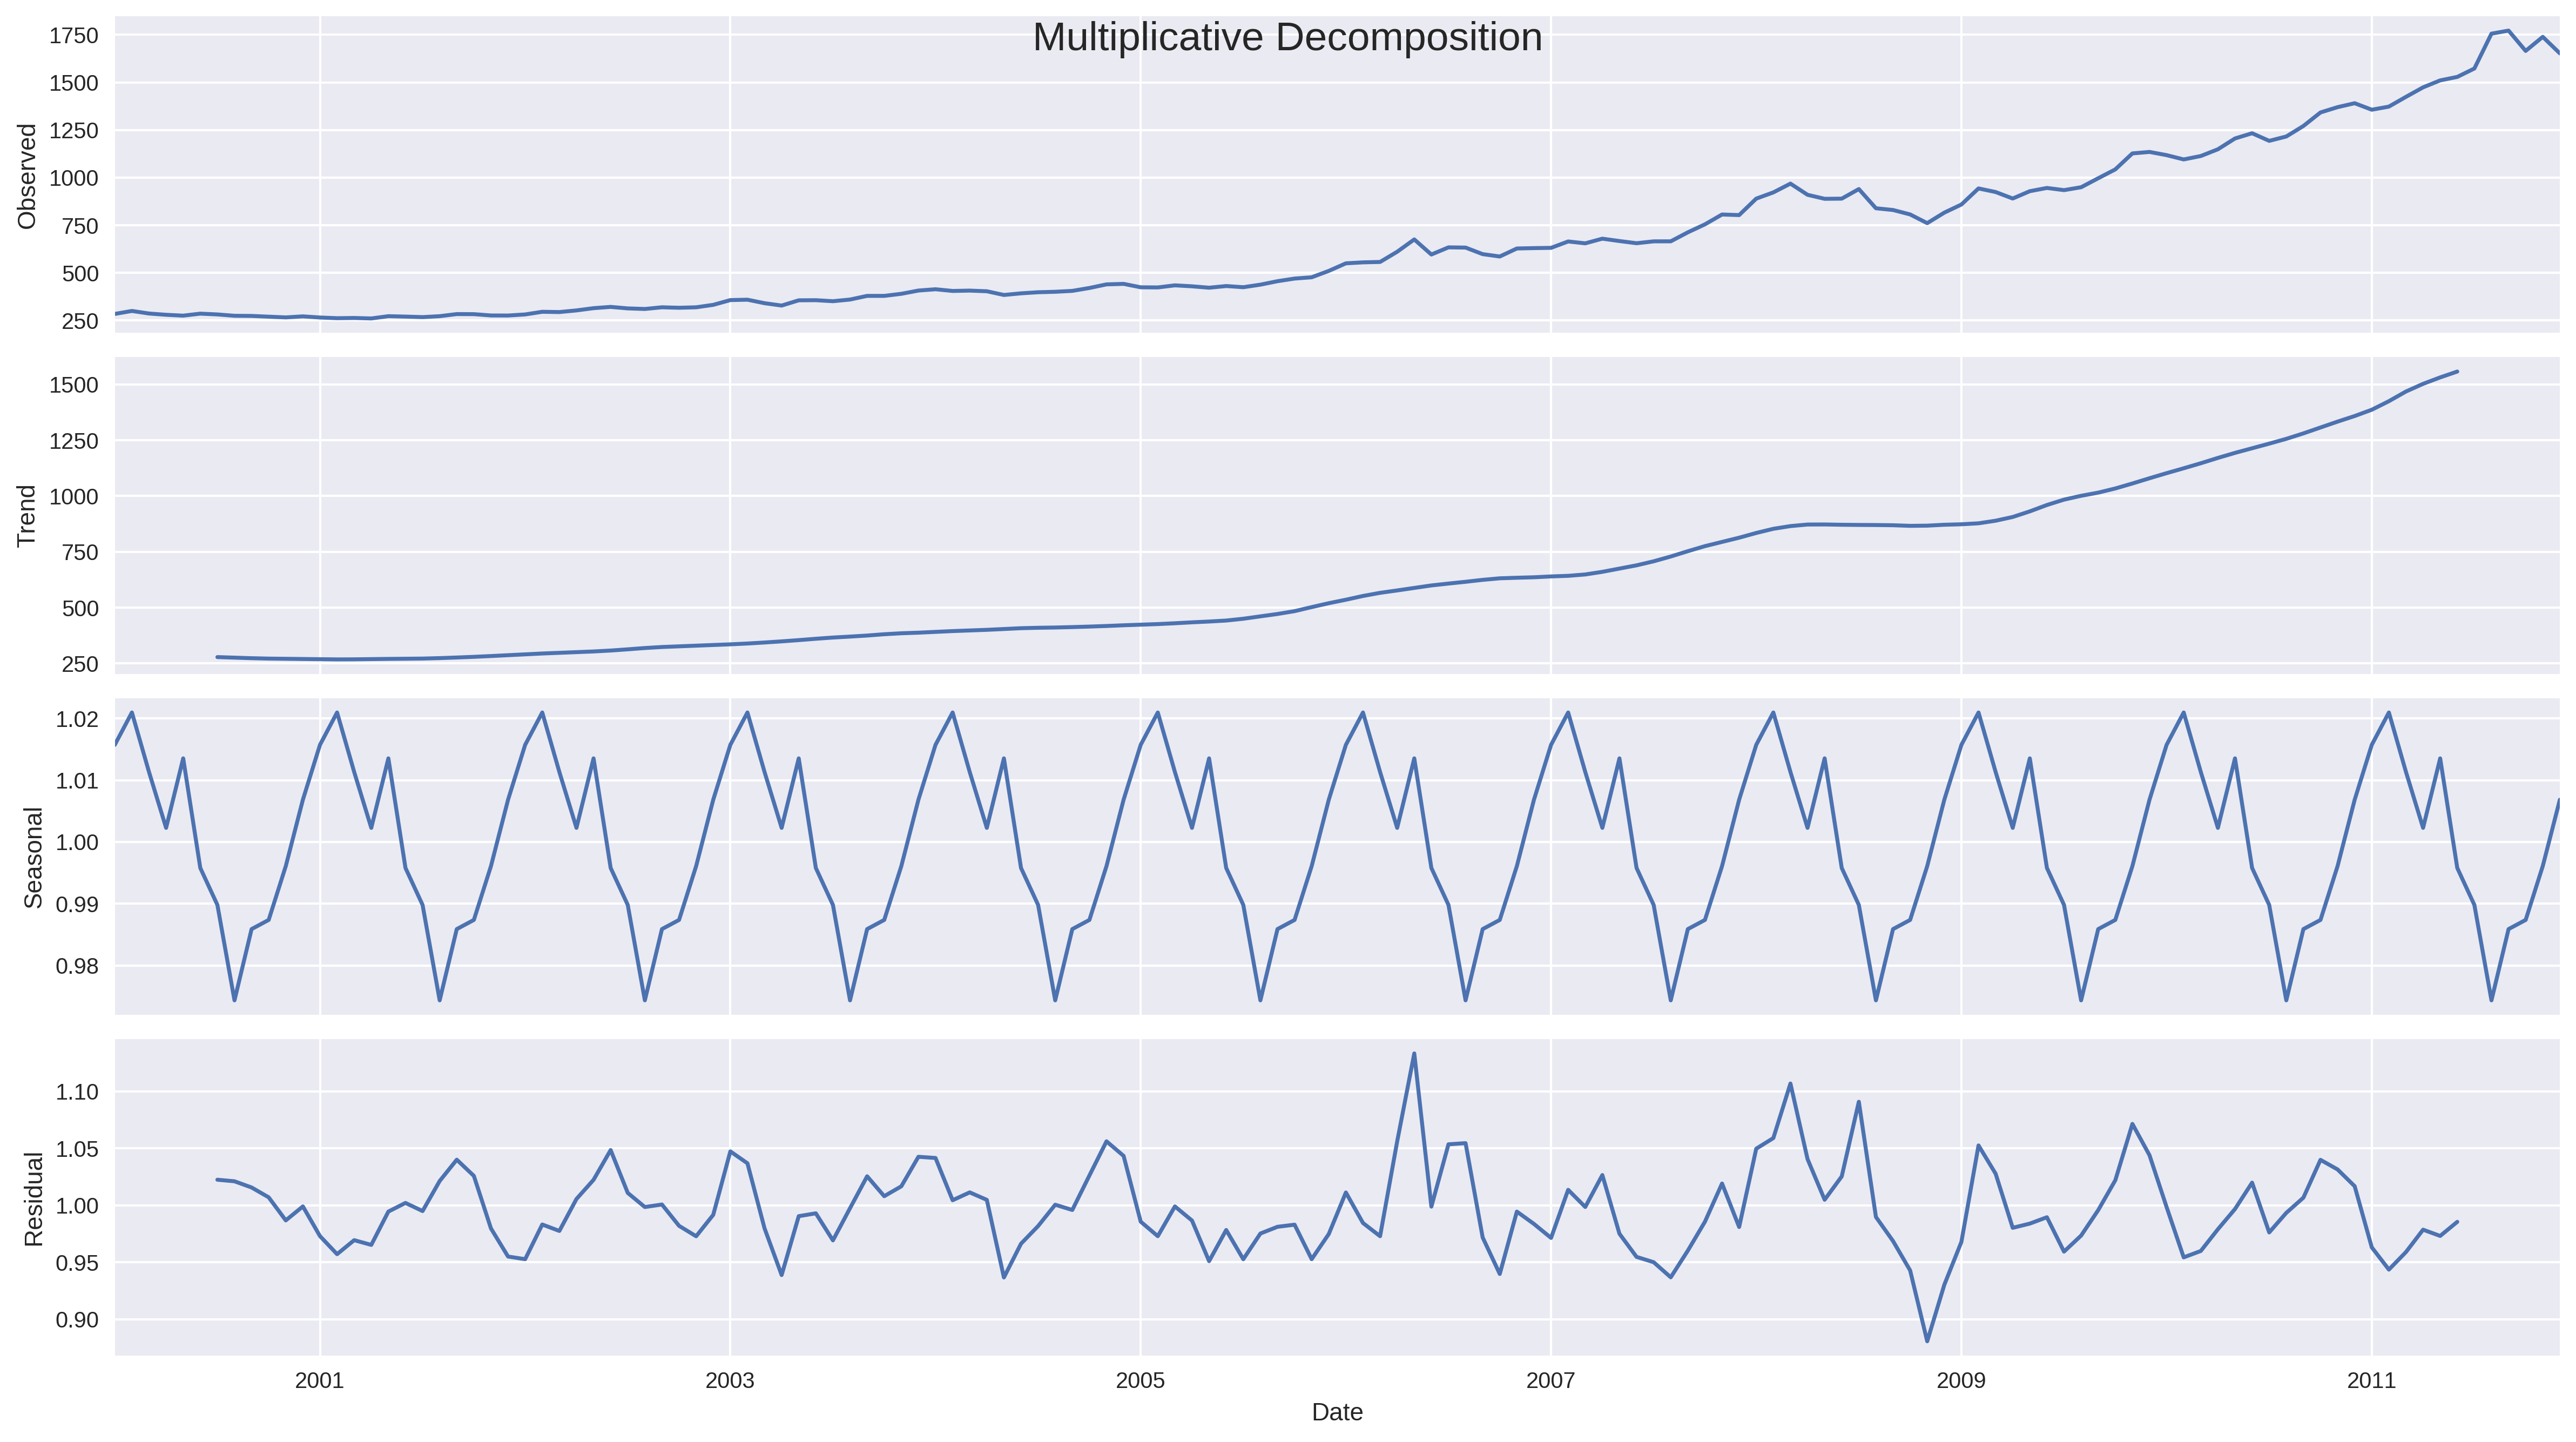

In [0]:
# Since the plot showed a non-linear rolling mean and the rolling standard deviation increased with time, we used the multiplicative model
decomposition_results = seasonal_decompose(df.price, model='multiplicative')
decomposition_results.plot() \
                     .suptitle('Multiplicative Decomposition', fontsize=18);
                     
# The extracted component series gave the observed price, the general trend, the seasonal, and the random (residual)
# The residual plot was indeed random so the fit makes sense
# If an additive model was applied, there would have been an increasing pattern in the over time
# In this case, it looks like the variance in the residuals was slightly higher in the second half of the dataset

In [0]:
# define the augmented Dickey-Fuller (ADF) test
def adf_test(x):
  indices = ['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used']
  adf_test = adfuller(x, autolag='AIC')
  results = pd.Series(adf_test[0:4], index=indices)
  for key, value in adf_test[4].items():
    results[f'Critical Value ({key})'] = value

    return results

In [0]:
# Run the test
adf_test(df.price)

Test Statistic              3.510499
p-value                     1.000000
# of Lags Used             14.000000
# of Observations Used    129.000000
Critical Value (1%)        -3.482088
dtype: float64

In [0]:
# Define the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
def kpss_test(x, h0_type='c'):
  indices = ['Test Statistic', 'p-value', '# of Lags']
  kpss_test = kpss(x, regression=h0_type)
  results = pd.Series(kpss_test[0:3], index=indices)
  for key, value in kpss_test[3].items():
    results[f'Critical Value ({key})'] = value
    
    return results

In [0]:
# Run the test
kpss_test(df.price)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Test Statistic           0.985671
p-value                  0.010000
# of Lags               14.000000
Critical Value (10%)     0.347000
dtype: float64

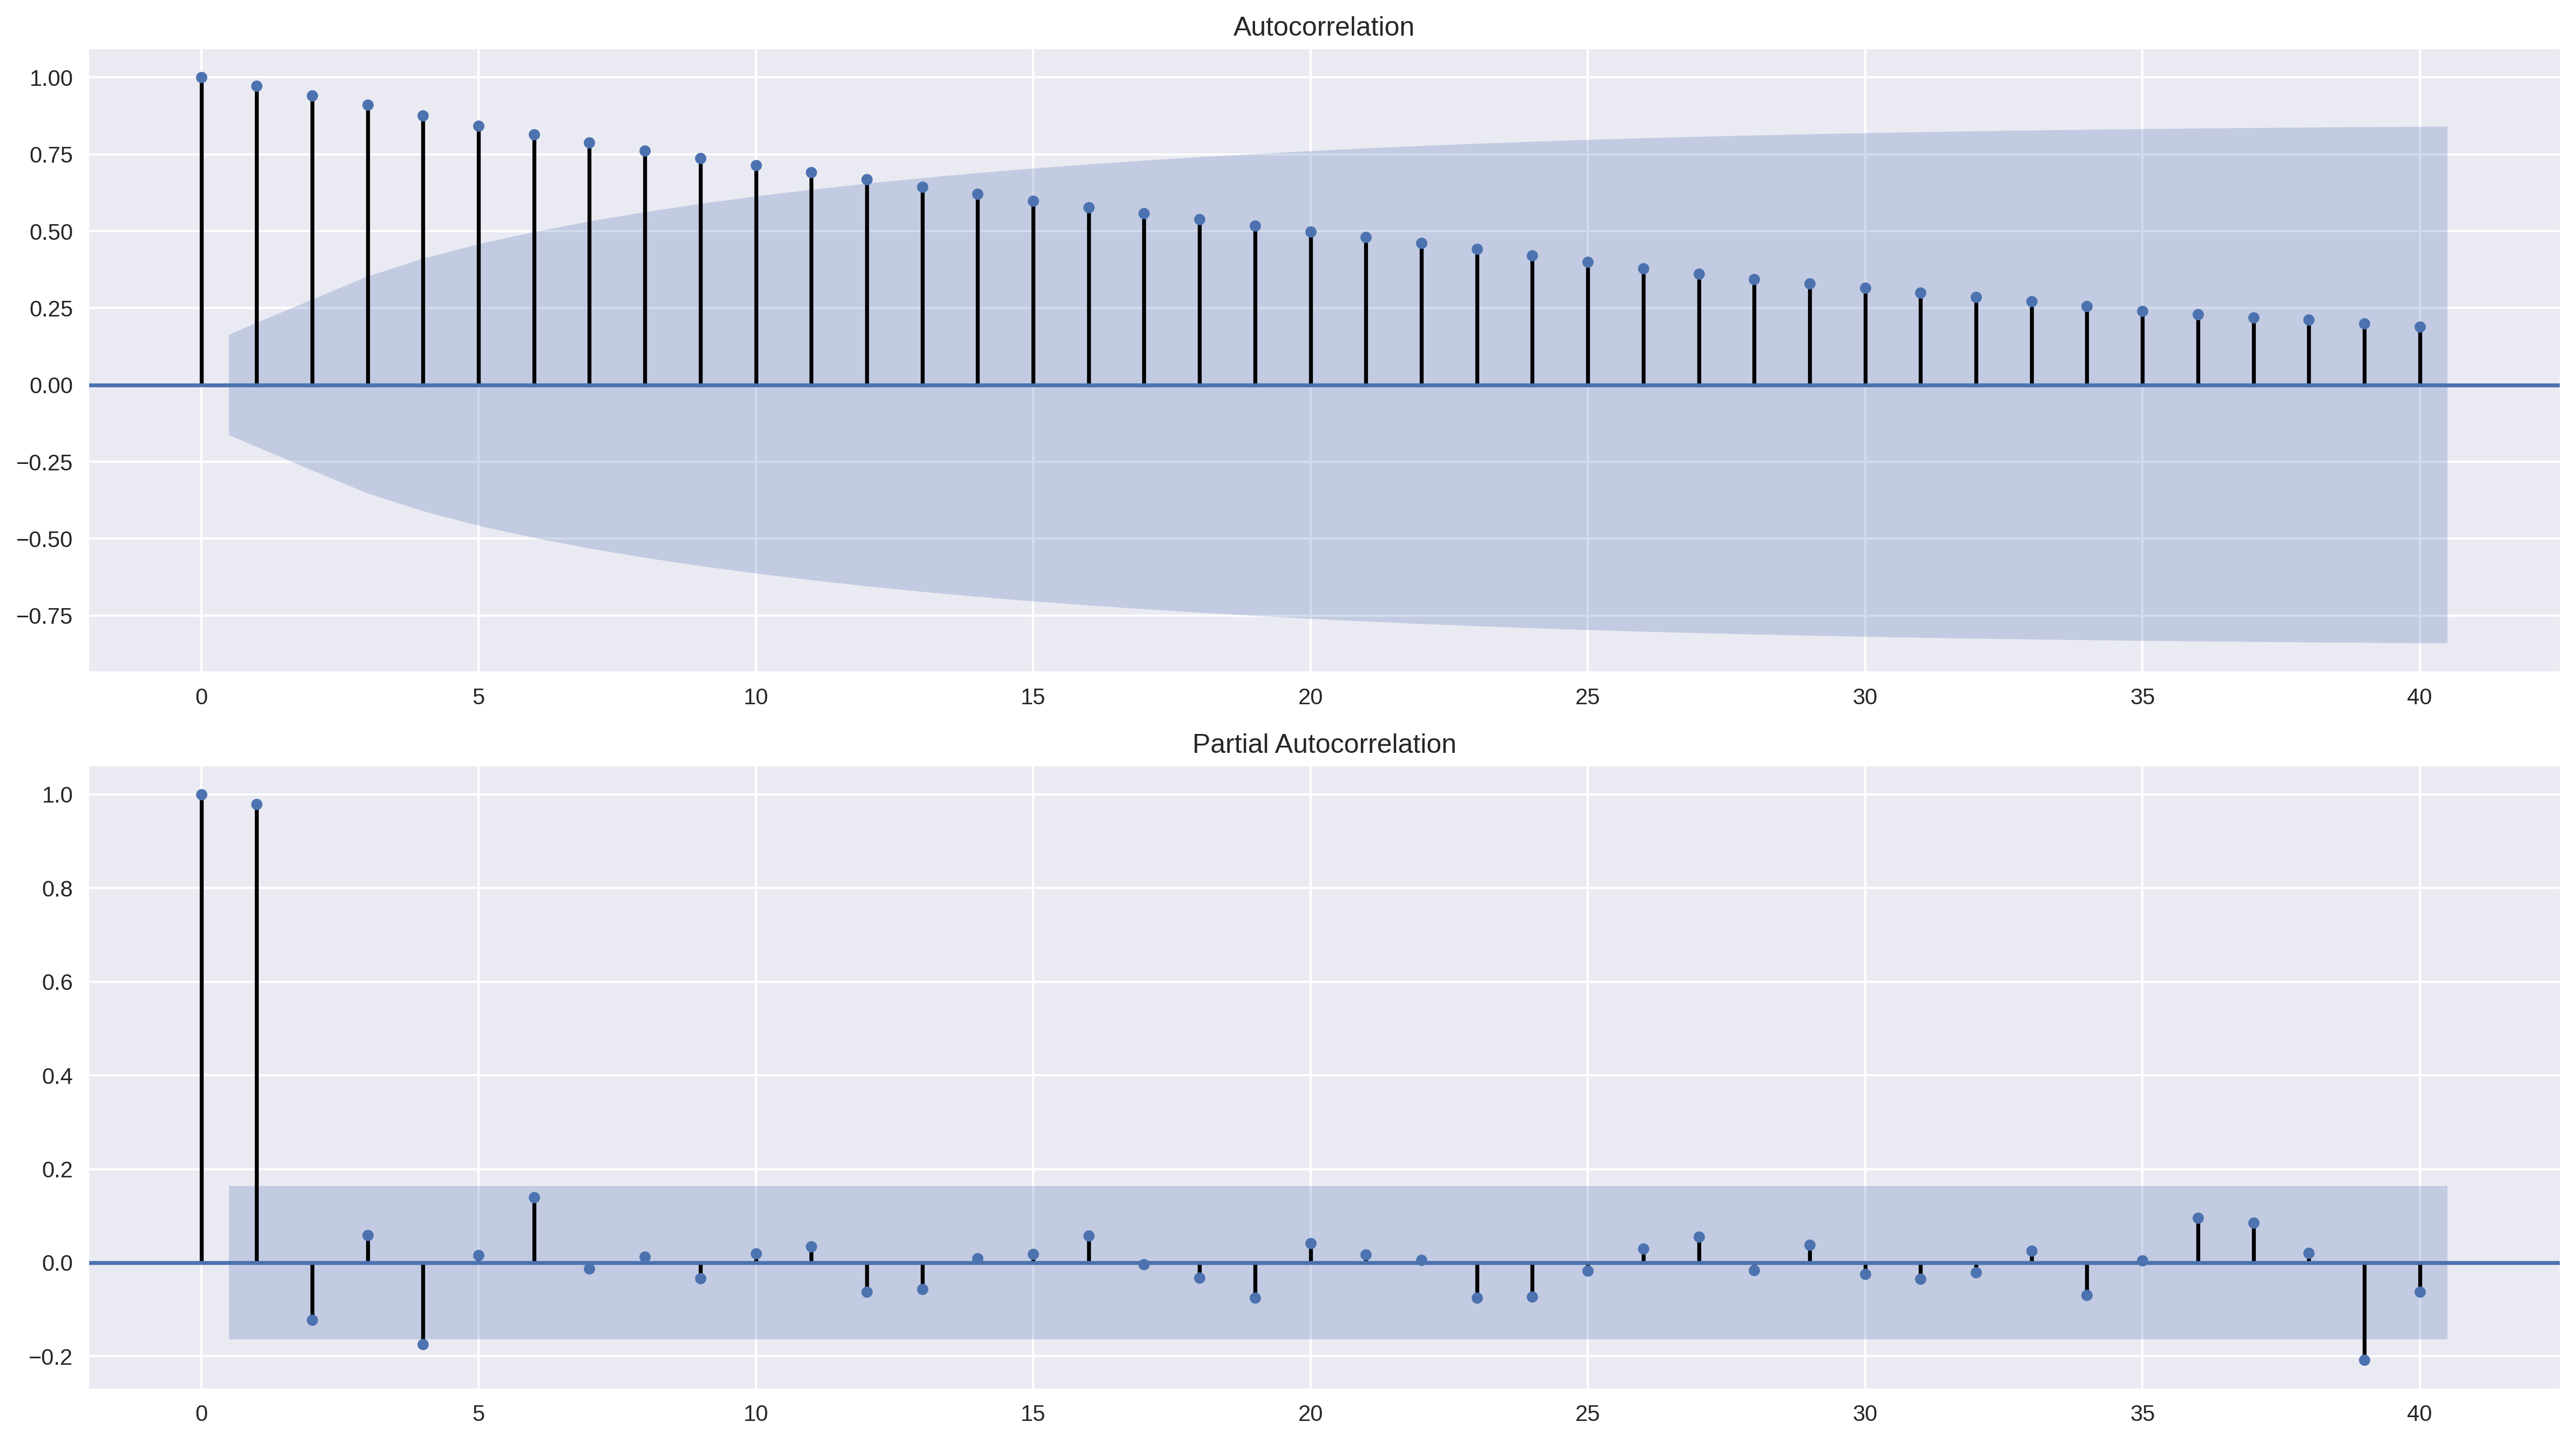

In [0]:
# Generate the autocorrelation and partial autocorrelation function (ACF/PACF) plots
N_LAGS = 40
SIGNIFICANCE_LEVEL = 0.05

fig, ax = plt.subplots(2,1)
plot_acf(df.price, ax=ax[0], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plot_pacf(df.price, ax=ax[1], lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.tight_layout()
plt.show()